In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
import datetime
import calendar

from pathlib import Path
from run_analysis import postprocess, preprocess, WINDOW_WIDTH
from Modules.DataCleaner import apply_window_wise
from scipy.interpolate import interp1d

sns.set_theme(style='darkgrid')

In [29]:
def to_timestamp(d):
  return calendar.timegm(d.timetuple())

class InterpolatedData:
    def __init__(self, x: pd.Series, y: np.ndarray):
        if type(x.values[0]) is np.datetime64:
            x = x.apply(to_timestamp)
        self.interpolator = interp1d(x, y)
    
    def get_vals(self, x: pd.Series):
        if type(x.values[0]) is np.datetime64:
            x = x.apply(to_timestamp)
        return self.interpolator(x)

def relative_percent_difference(df: pd.DataFrame, a: str, b: str):
#     return 2*(df[a] - df[b])/(np.abs(df[a]) + np.abs(df[b]))
    return np.abs(df[a] - df[b])/np.min((np.abs(df[a]), np.abs(df[b])), axis=0)

In [2]:
# ALL 2015 10min
eraDf = pd.read_csv(os.path.join('Analysis', '10min', 'eraDf.csv'))
remsDf = pd.read_csv(os.path.join('Analysis', '10min', 'remsDf.csv'))
outDf = pd.read_csv(os.path.join('Analysis', '10min', 'outDf_aggregated.csv'))

# ALL 2015 20min
# eraDf = pd.read_csv(os.path.join('Analysis', '20min', 'eraDf.csv'))
# remsDf = pd.read_csv(os.path.join('Analysis', '20min', 'remsDf.csv'))
# outDf = pd.read_csv(os.path.join('Analysis', '20min', 'outDf_aggregated.csv'))

np_load_modified = lambda *a,**k: np.load(*a, allow_pickle=True, **k)
with np_load_modified(os.path.join(os.getcwd(), 'Resources', 'REMS', f'meteo_Mar_wind.npz')) as metFile:
    timemet = metFile['timemet.npy']
    U_west_anem_10min = metFile['U_west_anem_10min.npy'] # 10min avg windspeed at flare bridge height (m/s)
    U_west_anem_1min = metFile['U_west_anem_1min.npy']
    U_west_10m_10min = metFile['U_west_10m_10min.npy'] # 10min avg at 10m
    U_west_10m_1min = metFile['U_west_10m_1min.npy']
    U_dirn_west_1 = metFile['U_dirn_west_1.npy']
    U_dirn_west_2 = metFile['U_dirn_west_2.npy']

for month in ['Apr', 'May']:
    with np_load_modified(os.path.join(os.getcwd(), 'Resources', 'REMS', f'meteo_{month}_wind.npz')) as metFile:
        timemet_temp = metFile['timemet.npy']
        U_west_anem_10min_temp = metFile['U_west_anem_10min.npy'] # 10min avg windspeed at flare bridge height (m/s)
        U_west_anem_1min_temp = metFile['U_west_anem_1min.npy']
        U_west_10m_10min_temp = metFile['U_west_10m_10min.npy'] # 10min avg at 10m
        U_west_10m_1min_temp = metFile['U_west_10m_1min.npy']
        U_dirn_west_1_temp = metFile['U_dirn_west_1.npy']
        U_dirn_west_2_temp = metFile['U_dirn_west_2.npy']
    
    timemet = np.concatenate((timemet, timemet_temp))
    U_west_anem_10min = np.concatenate((U_west_anem_10min, U_west_anem_10min_temp))
    U_west_anem_1min = np.concatenate((U_west_anem_1min, U_west_anem_1min_temp))
    U_west_10m_10min = np.concatenate((U_west_10m_10min, U_west_10m_10min_temp))
    U_west_10m_1min = np.concatenate((U_west_10m_1min, U_west_10m_1min_temp))
    U_dirn_west_1 = np.concatenate((U_dirn_west_1, U_dirn_west_1_temp))
    U_dirn_west_2 = np.concatenate((U_dirn_west_2, U_dirn_west_2_temp))
    
windDf = pd.DataFrame({"timemet": timemet, "U_west_10m_10min": U_west_10m_10min, "U_west_10m_1min": U_west_10m_1min,
                        "U_west_anem_10min": U_west_anem_10min, "U_west_anem_1min": U_west_anem_1min,
                        "U_dirn_west_1": U_dirn_west_1, "U_dirn_west_2": U_dirn_west_2})
windDf.sort_values(by='timemet', inplace=True)

remsDf.timemet = remsDf.timemet.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
eraDf.timemet = eraDf.timemet.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
outDf.time = outDf.time.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [3]:
print(outDf.time.min())
print(outDf.time.max())

era_only = True

# Apr GUST
# time_lim = [datetime.datetime.strptime("2015-04-19 05:00:00", '%Y-%m-%d %H:%M:%S'), 
#             datetime.datetime.strptime("2015-04-19 10:00:00", '%Y-%m-%d %H:%M:%S')]
# time_lim = [datetime.datetime.strptime("2015-04-18 00:00:00", '%Y-%m-%d %H:%M:%S'), 
#             datetime.datetime.strptime("2015-04-28 23:00:00", '%Y-%m-%d %H:%M:%S')]

# QUANG
time_lim = [datetime.datetime.strptime("2015-04-27 00:00:00", '%Y-%m-%d %H:%M:%S'), 
            datetime.datetime.strptime("2015-05-3 00:00:00", '%Y-%m-%d %H:%M:%S')]

# OLWYN 
# time_lim = [datetime.datetime.strptime("2015-03-01 00:00:00", '%Y-%m-%d %H:%M:%S'), 
#             datetime.datetime.strptime("2015-03-29 23:00:00", '%Y-%m-%d %H:%M:%S')]
# time_lim = [datetime.datetime.strptime("2015-03-08 00:00:00", '%Y-%m-%d %H:%M:%S'), 
#             datetime.datetime.strptime("2015-03-14 23:00:00", '%Y-%m-%d %H:%M:%S')]

# # VERONICA
# time_lim = [datetime.datetime.strptime("2019-03-20 00:00:00", '%Y-%m-%d %H:%M:%S'), 
#             datetime.datetime.strptime("2019-03-25 23:00:00", '%Y-%m-%d %H:%M:%S')]

# ALL 2015
# time_lim = [datetime.datetime.strptime("2015-04-10 00:00:00", '%Y-%m-%d %H:%M:%S'), 
#             datetime.datetime.strptime("2015-04-20 00:00:00", '%Y-%m-%d %H:%M:%S')]

# time_lim = None

2015-01-01 08:00:00
2016-01-01 01:40:00


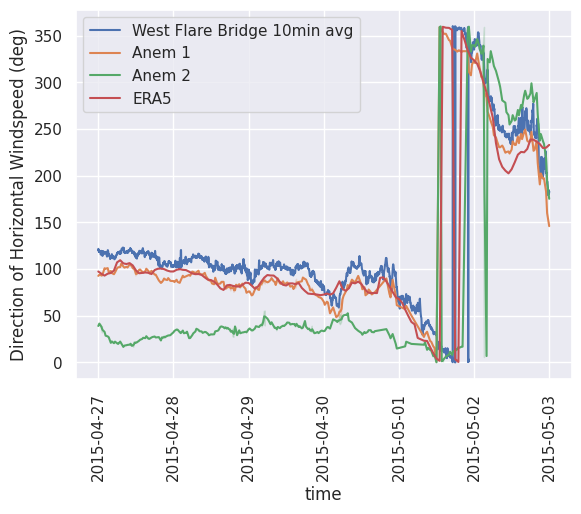

In [255]:
# QUANG 20min
logoutDf = outDf[(outDf.time >= time_lim[0]) & (outDf.time <= time_lim[1])]
logeraDf = eraDf[(eraDf.timemet >= time_lim[0]) & (eraDf.timemet <= time_lim[1])]
logwindDf = windDf[(windDf.timemet >= time_lim[0]) & (windDf.timemet <= time_lim[1])]

sns.lineplot(data=logwindDf, x='timemet', y='U_dirn_west_1', label='West Flare Bridge 10min avg')
sns.lineplot(x=logoutDf.time, y=np.rad2deg(np.arctan2(logoutDf.v1, logoutDf.u1))+180, label='Anem 1')
sns.lineplot(x=logoutDf.time, y=np.rad2deg(np.arctan2(logoutDf.v2, logoutDf.u2))+180, label='Anem 2')
sns.lineplot(x=logeraDf.timemet, y=np.rad2deg(np.arctan2(logeraDf.u_10, logeraDf.v_10))+180, label='ERA5')
plt.xlabel('time')
plt.ylabel('Direction of Horizontal Windspeed (deg)')
plt.xticks(plt.xticks()[0], rotation=90)
plt.show()

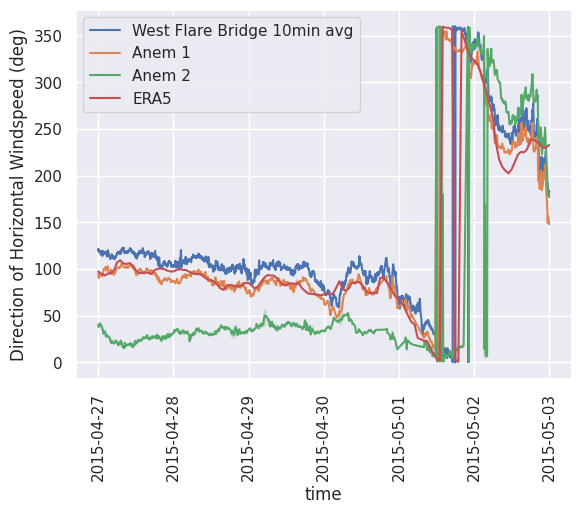

In [187]:
# QUANG
logoutDf = outDf[(outDf.time >= time_lim[0]) & (outDf.time <= time_lim[1])]
logeraDf = eraDf[(eraDf.timemet >= time_lim[0]) & (eraDf.timemet <= time_lim[1])]
logwindDf = windDf[(windDf.timemet >= time_lim[0]) & (windDf.timemet <= time_lim[1])]

sns.lineplot(data=logwindDf, x='timemet', y='U_dirn_west_1', label='West Flare Bridge 10min avg')
sns.lineplot(x=logoutDf.time, y=np.rad2deg(np.arctan2(logoutDf.v1, logoutDf.u1))+180, label='Anem 1')
sns.lineplot(x=logoutDf.time, y=np.rad2deg(np.arctan2(logoutDf.v2, logoutDf.u2))+180, label='Anem 2')
sns.lineplot(x=logeraDf.timemet, y=np.rad2deg(np.arctan2(logeraDf.u_10, logeraDf.v_10))+180, label='ERA5')
plt.xlabel('time')
plt.ylabel('Direction of Horizontal Windspeed (deg)')
plt.xticks(plt.xticks()[0], rotation=90)
plt.show()

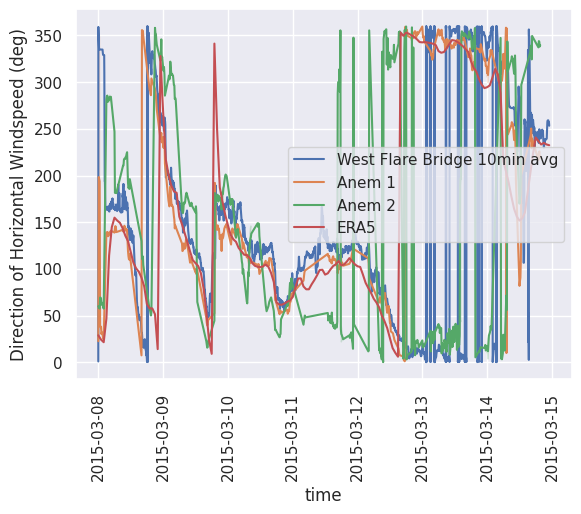

In [71]:
# OLWYN
logoutDf = outDf[(outDf.time >= time_lim[0]) & (outDf.time <= time_lim[1])]
logeraDf = eraDf[(eraDf.timemet >= time_lim[0]) & (eraDf.timemet <= time_lim[1])]
logwindDf = windDf[(windDf.timemet >= time_lim[0]) & (windDf.timemet <= time_lim[1])]

sns.lineplot(data=logwindDf, x='timemet', y='U_dirn_west_1', label='West Flare Bridge 10min avg')
sns.lineplot(x=logoutDf.time, y=np.rad2deg(np.arctan2(logoutDf.v1, logoutDf.u1))+180, label='Anem 1')
sns.lineplot(x=logoutDf.time, y=np.rad2deg(np.arctan2(logoutDf.v2, logoutDf.u2))+180, label='Anem 2')
sns.lineplot(x=logeraDf.timemet, y=np.rad2deg(np.arctan2(logeraDf.u_10, logeraDf.v_10))+180, label='ERA5')
plt.xlabel('time')
plt.ylabel('Direction of Horizontal Windspeed (deg)')
plt.xticks(plt.xticks()[0], rotation=90)
plt.show()

Exception ignored in: <function WeakMethod.__new__.<locals>._cb at 0x7f31e706cb80>
Traceback (most recent call last):
  File "/usr/lib/python3.8/weakref.py", line 51, in _cb
    def _cb(arg):
KeyboardInterrupt: 


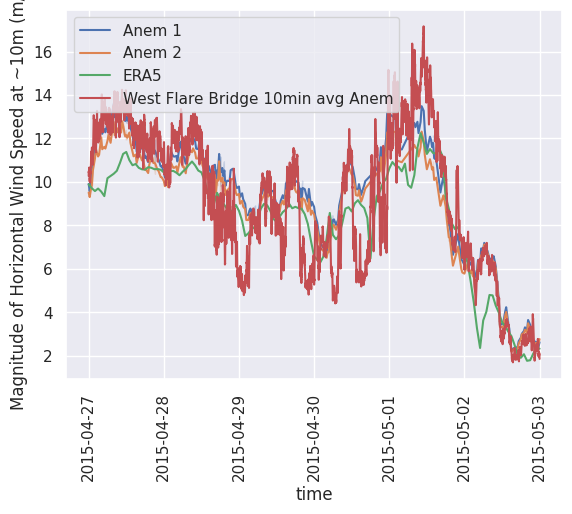

In [268]:
# Gust 20min
logoutDf = outDf[(outDf.time >= time_lim[0]) & (outDf.time <= time_lim[1])]
logeraDf = eraDf[(eraDf.timemet >= time_lim[0]) & (eraDf.timemet <= time_lim[1])]
logwindDf = windDf[(windDf.timemet >= time_lim[0]) & (windDf.timemet <= time_lim[1])]

sns.lineplot(data=logoutDf, x='time', y='U_anem_1', label='Anem 1')
sns.lineplot(data=logoutDf, x='time', y='U_anem_2', label='Anem 2')
sns.lineplot(x=logeraDf.timemet, y=np.linalg.norm(logeraDf[['v_10', 'u_10']].values,axis=1), label='ERA5')
sns.lineplot(data=logwindDf, x='timemet', y='U_west_anem_10min', label='West Flare Bridge 10min avg Anem')
plt.xlabel('time')
plt.ylabel('Magnitude of Horizontal Wind Speed at ~10m (m/s)')
plt.xticks(plt.xticks()[0], rotation=90)
plt.show()

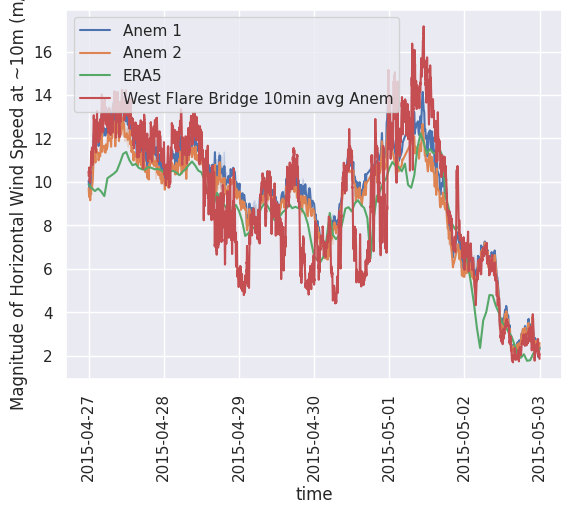

In [5]:
logoutDf = outDf[(outDf.time >= time_lim[0]) & (outDf.time <= time_lim[1])]
logeraDf = eraDf[(eraDf.timemet >= time_lim[0]) & (eraDf.timemet <= time_lim[1])]
logwindDf = windDf[(windDf.timemet >= time_lim[0]) & (windDf.timemet <= time_lim[1])]

sns.lineplot(data=logoutDf, x='time', y='U_anem_1', label='Anem 1')
sns.lineplot(data=logoutDf, x='time', y='U_anem_2', label='Anem 2')
sns.lineplot(x=logeraDf.timemet, y=np.linalg.norm(logeraDf[['v_10', 'u_10']].values,axis=1), label='ERA5')
sns.lineplot(data=logwindDf, x='timemet', y='U_west_anem_10min', label='West Flare Bridge 10min avg Anem')
plt.xlabel('time')
plt.ylabel('Magnitude of Horizontal Wind Speed at ~10m (m/s)')
plt.xticks(plt.xticks()[0], rotation=90)
plt.show()

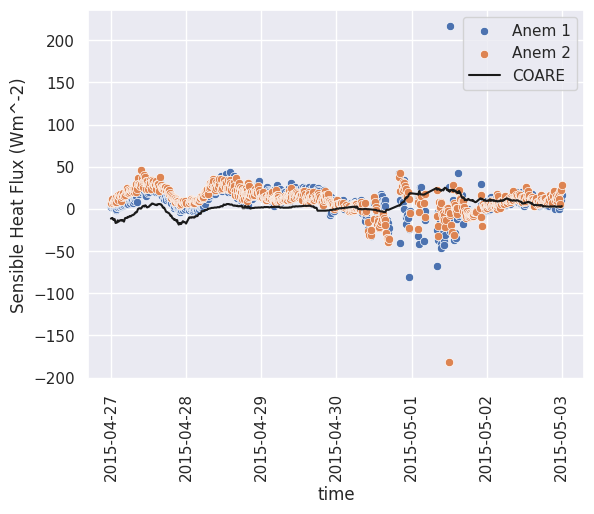

In [12]:
logoutDf = outDf[(outDf.time >= time_lim[0]) & (outDf.time <= time_lim[1])]
logeraDf = eraDf[(eraDf.timemet >= time_lim[0]) & (eraDf.timemet <= time_lim[1])]
logwindDf = windDf[(windDf.timemet >= time_lim[0]) & (windDf.timemet <= time_lim[1])]

sns.scatterplot(data=logoutDf, x='time', y='HApprox_1', label='Anem 1')
sns.scatterplot(data=logoutDf, x='time', y='HApprox_2', label='Anem 2')
sns.lineplot(data=logoutDf, x='time', y='HCoare_1', label='COARE', color='k')
plt.ylabel('Sensible Heat Flux (Wm^-2)')
plt.xticks(plt.xticks()[0], rotation=90)
plt.show()

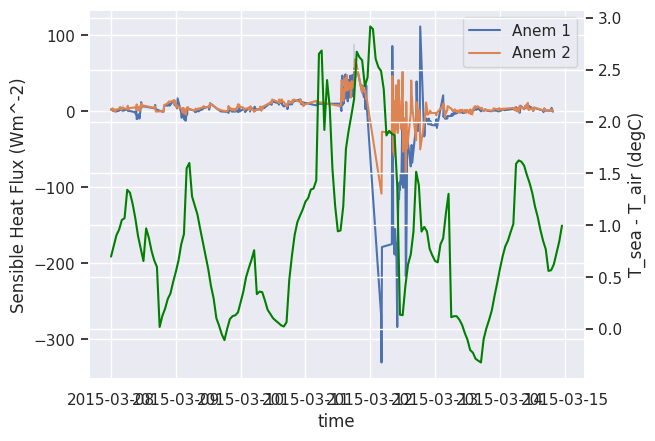

In [91]:
# OLWYN
logoutDf = outDf[(outDf.time >= time_lim[0]) & (outDf.time <= time_lim[1])]
logeraDf = eraDf[(eraDf.timemet >= time_lim[0]) & (eraDf.timemet <= time_lim[1])]

sns.lineplot(data=logoutDf, x='time', y='HApprox_1', label='Anem 1')
sns.lineplot(data=logoutDf, x='time', y='HApprox_2', label='Anem 2')
plt.xlabel('time')
# plt.xticks(plt.xticks()[0], rotation=90)
plt.ylabel('Sensible Heat Flux (Wm^-2)')

ax2 = plt.twinx()
ax2.set_ylabel('T_sea - T_air (degC)')
sns.lineplot(x=logeraDf.timemet, y=logeraDf.tsea - logeraDf.ta, ax=ax2, color='green')
plt.show()

<AxesSubplot: xlabel='time', ylabel='U_anem_1'>

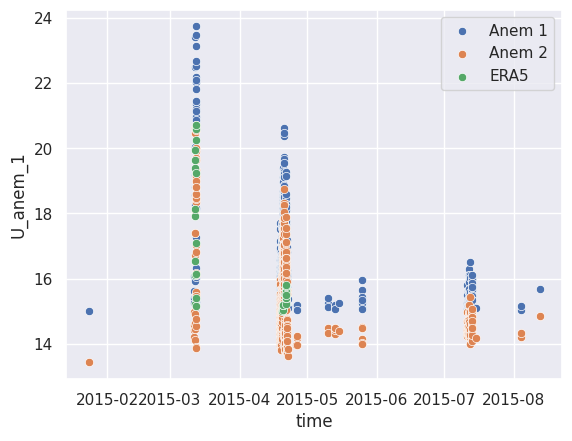

In [203]:
# 2015
logoutDf = outDf[(outDf.U_anem_1 >= 15) | (outDf.U_anem_2 >= 15)]
logeraDf = eraDf[np.linalg.norm(eraDf[['v_10', 'u_10']].values,axis=1) >= 15]

sns.scatterplot(data=logoutDf, x='time', y='U_anem_1', label='Anem 1')
sns.scatterplot(data=logoutDf, x='time', y='U_anem_2', label='Anem 2')
sns.scatterplot(x=logeraDf.timemet, y=np.linalg.norm(logeraDf[['v_10', 'u_10']].values,axis=1), label='ERA5')

<AxesSubplot: xlabel='time', ylabel='U_anem_1'>

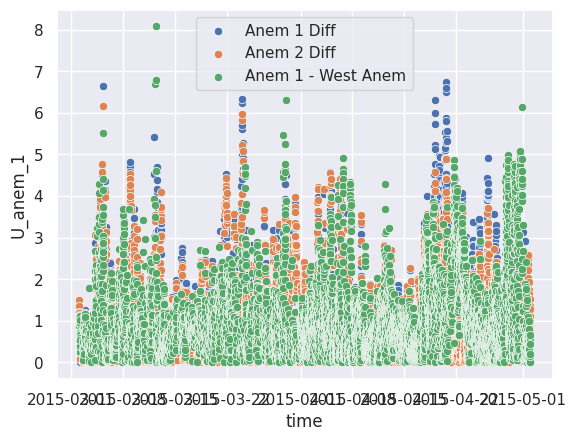

In [219]:
# 2015
logoutDf = outDf[(outDf.time > datetime.datetime.strptime("2015-03-02 00:00:00", '%Y-%m-%d %H:%M:%S')) & 
                (outDf.time < datetime.datetime.strptime("2015-05-02 00:00:00", '%Y-%m-%d %H:%M:%S'))]#[(outDf.U_anem_1 >= 15) | (outDf.U_anem_2 >= 15)]
logeraDf = eraDf#[np.linalg.norm(eraDf[['v_10', 'u_10']].values,axis=1) >= 15]

era_wind = InterpolatedData(x=logeraDf.timemet, y=np.linalg.norm(logeraDf[['v_10', 'u_10']].values,axis=1))
rems_wind = InterpolatedData(x=windDf.timemet, y=windDf.U_west_10m_10min)
sns.scatterplot(x=logoutDf.time, y=np.abs(logoutDf.U_anem_1 - era_wind.get_vals(logoutDf.time)), label='Anem 1 Diff')
sns.scatterplot(x=logoutDf.time, y=np.abs(logoutDf.U_anem_2 - era_wind.get_vals(logoutDf.time)), label='Anem 2 Diff')
sns.scatterplot(x=logoutDf.time, y=np.abs(logoutDf.U_anem_1 - rems_wind.get_vals(logoutDf.time)), label='Anem 1 - West Anem')

<AxesSubplot: xlabel='timemet', ylabel='crr'>

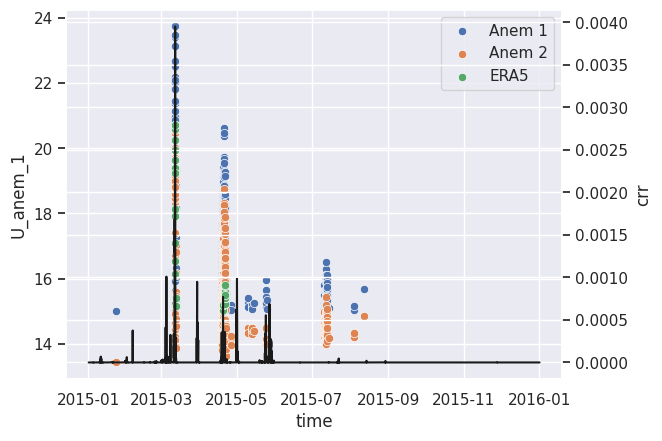

In [13]:
# 2015
logoutDf = outDf[(outDf.U_anem_1 >= 15) | (outDf.U_anem_2 >= 15)]
logeraDf = eraDf[np.linalg.norm(eraDf[['v_10', 'u_10']].values,axis=1) >= 15]
sns.scatterplot(data=logoutDf, x='time', y='U_anem_1', label='Anem 1')
sns.scatterplot(data=logoutDf, x='time', y='U_anem_2', label='Anem 2')
sns.scatterplot(x=logeraDf.timemet, y=np.linalg.norm(logeraDf[['v_10', 'u_10']].values,axis=1), label='ERA5')

ax2 = plt.twinx()
ax2.set_ylabel('crr')
sns.lineplot(data=eraDf, x='timemet', y='crr', ax=ax2, color='k')

<AxesSubplot: xlabel='timemet', ylabel='Convective Rain Rate'>

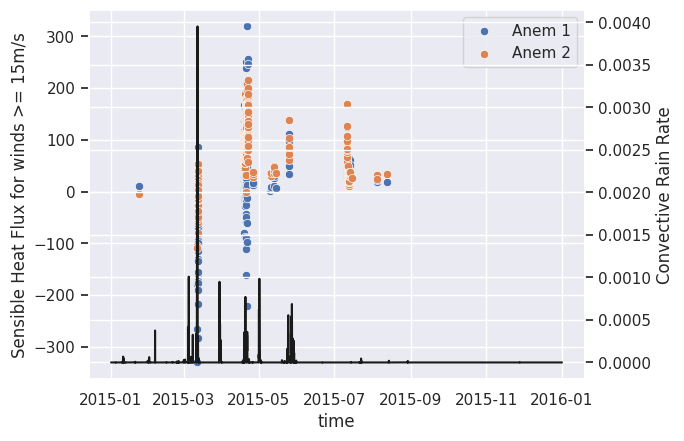

In [17]:
# 2015
logoutDf = outDf[(outDf.U_anem_1 >= 15) | (outDf.U_anem_2 >= 15)]

sns.scatterplot(data=logoutDf, x='time', y='HApprox_1', label='Anem 1')
sns.scatterplot(data=logoutDf, x='time', y='HApprox_2', label='Anem 2')
# sns.scatterplot(data=logoutDf, x='time', y='HCoare_1', label='Anem 1')
# sns.scatterplot(data=logoutDf, x='time', y='HCoare_2', label='Anem 2')
plt.ylabel('Sensible Heat Flux for winds >= 15m/s')

ax2 = plt.twinx()
ax2.set_ylabel('Convective Rain Rate')
sns.lineplot(data=eraDf, x='timemet', y='crr', ax=ax2, color='k')

In [52]:
print(len(outDf[np.abs(outDf['HApprox_2'] - outDf['HApprox_1']) < 18])/len(outDf))

0.9007139567019806


Text(0, 0.5, 'Sensible Heat Flux (Wm^-2)')

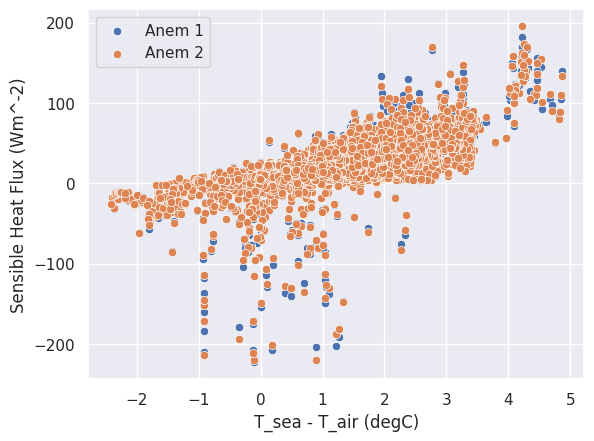

In [63]:
# 2015
# logoutDf = outDf[np.abs(outDf['HApprox_2'] - outDf['HApprox_1']) < 18]
logoutDf = outDf[relative_percent_difference(outDf, 'HApprox_1', 'HApprox_2') < 0.1]
logeraDf = eraDf

tempdiff = InterpolatedData(x=logeraDf.timemet, y=logeraDf.tsea - logeraDf.ta)
sns.scatterplot(x=tempdiff.get_vals(logoutDf.time), y=logoutDf.HApprox_1, label='Anem 1')
sns.scatterplot(x=tempdiff.get_vals(logoutDf.time), y=logoutDf.HApprox_2, label='Anem 2')
plt.xlabel('T_sea - T_air (degC)')
plt.ylabel('Sensible Heat Flux (Wm^-2)')

Text(0, 0.5, 'Sensible Heat Flux (Wm^-2)')

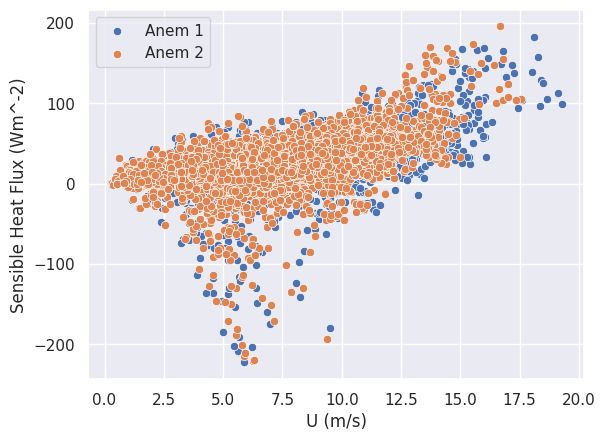

In [57]:
# 2015
# logoutDf = outDf[np.abs(outDf['HApprox_2'] - outDf['HApprox_1']) < 18]
logoutDf = outDf[relative_percent_difference(outDf, 'HApprox_1', 'HApprox_2') < 0.1]
logeraDf = eraDf

sns.scatterplot(data=logoutDf, x='U_anem_1', y='HApprox_1', label='Anem 1')
sns.scatterplot(data=logoutDf, x='U_anem_2', y='HApprox_2', label='Anem 2')
plt.xlabel('U (m/s)')
plt.ylabel('Sensible Heat Flux (Wm^-2)')

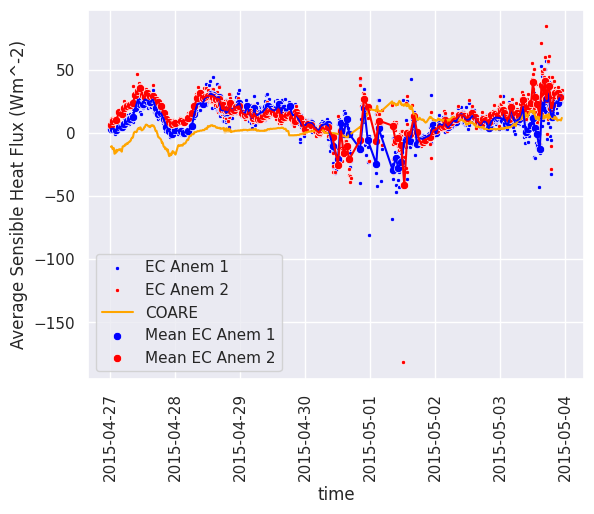

In [43]:
# Quang
logDf = outDf[(outDf.time > datetime.datetime(2015, 4, 27, 0, 0)) & (outDf.time < datetime.datetime(2015, 5, 3, 23, 0))]
logDf = logDf[relative_percent_difference(logDf, 'HApprox_1', 'HApprox_2') < 20]
mean_ec_1 = apply_window_wise(logDf['HApprox_1'], WINDOW_WIDTH, np.mean)
mean_ec_2 = apply_window_wise(logDf['HApprox_2'], WINDOW_WIDTH, np.mean)
sns.scatterplot(x=logDf['time'], y=logDf['HApprox_1'], marker='.', color='blue', label='EC Anem 1')
sns.scatterplot(x=logDf['time'], y=logDf['HApprox_2'], marker='.', color='red', label='EC Anem 2')
sns.lineplot(data=logDf, x='time', y='HCoare_1', color='orange', label='COARE')
sns.scatterplot(x=logDf.time[::WINDOW_WIDTH], y=mean_ec_1, color='blue', label='Mean EC Anem 1')
sns.scatterplot(x=logDf.time[::WINDOW_WIDTH], y=mean_ec_2, color='red', label='Mean EC Anem 2')
sns.lineplot(x=logDf.time[::WINDOW_WIDTH], y=mean_ec_1, color='blue')
sns.lineplot(x=logDf.time[::WINDOW_WIDTH], y=mean_ec_2, color='red')
plt.xlabel('time')
plt.ylabel('Average Sensible Heat Flux (Wm^-2)')
plt.xticks(plt.xticks()[0], rotation=90)
plt.show()

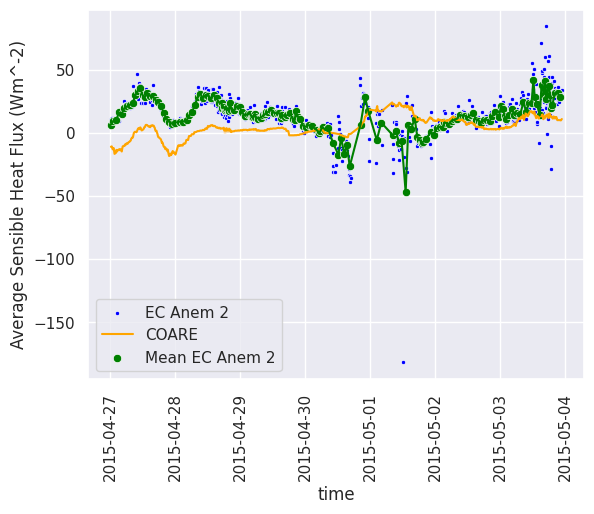

In [34]:
# Quang
logDf = outDf[(outDf.time > datetime.datetime(2015, 4, 27, 0, 0)) & (outDf.time < datetime.datetime(2015, 5, 3, 23, 0))]
logDf = logDf[relative_percent_difference(logDf, 'HApprox_1', 'HApprox_2') < 25]
# mean_ec = apply_window_wise((logDf['HApprox_1'] + logDf['HApprox_2'])/2, WINDOW_WIDTH, np.mean)
# sns.scatterplot(x=logDf['time'], y=(logDf['HApprox_1'] + logDf['HApprox_2'])/2, marker='.', color='blue', label='EC')
mean_ec = apply_window_wise(logDf['HApprox_2'], WINDOW_WIDTH, np.mean)
sns.scatterplot(x=logDf['time'], y=logDf['HApprox_2'], marker='.', color='blue', label='EC Anem 2')
sns.lineplot(data=logDf, x='time', y='HCoare_2', color='orange', label='COARE')
sns.scatterplot(x=logDf.time[::WINDOW_WIDTH], y=mean_ec, color='green', label='Mean EC Anem 2')
sns.lineplot(x=logDf.time[::WINDOW_WIDTH], y=mean_ec, color='green')
plt.xlabel('time')
plt.ylabel('Average Sensible Heat Flux (Wm^-2)')
plt.xticks(plt.xticks()[0], rotation=90)
plt.show()

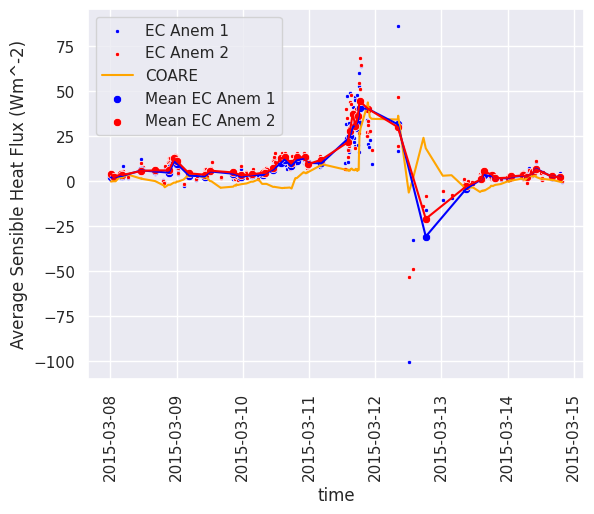

In [48]:
# Olwyn
logDf = outDf[(outDf.time > datetime.datetime(2015, 3, 8, 0, 0)) & (outDf.time < datetime.datetime(2015, 3, 14, 23, 0))]
logDf = logDf[relative_percent_difference(logDf, 'HApprox_1', 'HApprox_2') < 1]
mean_ec_1 = apply_window_wise(logDf['HApprox_1'], WINDOW_WIDTH, np.mean)
mean_ec_2 = apply_window_wise(logDf['HApprox_2'], WINDOW_WIDTH, np.mean)
sns.scatterplot(x=logDf['time'], y=logDf['HApprox_1'], marker='.', color='blue', label='EC Anem 1')
sns.scatterplot(x=logDf['time'], y=logDf['HApprox_2'], marker='.', color='red', label='EC Anem 2')
sns.lineplot(data=logDf, x='time', y='HCoare_1', color='orange', label='COARE')
sns.scatterplot(x=logDf.time[::WINDOW_WIDTH], y=mean_ec_1, color='blue', label='Mean EC Anem 1')
sns.scatterplot(x=logDf.time[::WINDOW_WIDTH], y=mean_ec_2, color='red', label='Mean EC Anem 2')
sns.lineplot(x=logDf.time[::WINDOW_WIDTH], y=mean_ec_1, color='blue')
sns.lineplot(x=logDf.time[::WINDOW_WIDTH], y=mean_ec_2, color='red')
plt.xlabel('time')
plt.ylabel('Average Sensible Heat Flux (Wm^-2)')
plt.xticks(plt.xticks()[0], rotation=90)
plt.show()

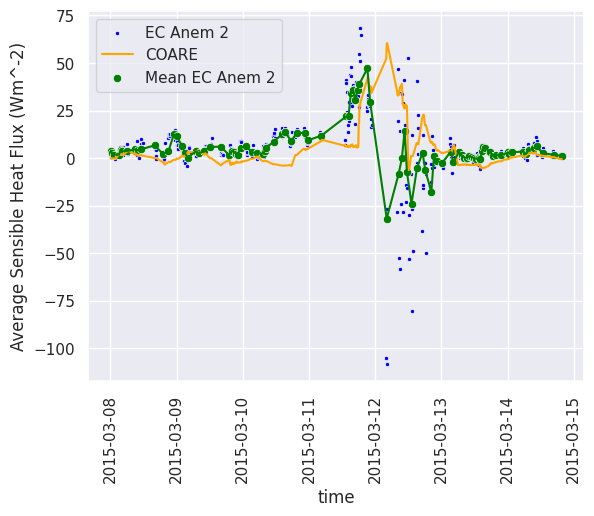

In [34]:
# Olwyn
logDf = outDf[(outDf.time > datetime.datetime(2015, 3, 8, 0, 0)) & (outDf.time < datetime.datetime(2015, 3, 14, 23, 0))]
# mean_ec = apply_window_wise((logDf['HApprox_1'] + logDf['HApprox_2'])/2, WINDOW_WIDTH, np.mean)
# sns.scatterplot(x=logDf['time'], y=(logDf['HApprox_1'] + logDf['HApprox_2'])/2, marker='.', color='blue', label='EC')
mean_ec = apply_window_wise(logDf['HApprox_2'], WINDOW_WIDTH, np.mean)
sns.scatterplot(x=logDf['time'], y=logDf['HApprox_2'], marker='.', color='blue', label='EC Anem 2')
sns.lineplot(data=logDf, x='time', y='HCoare_2', color='orange', label='COARE')
sns.scatterplot(x=logDf.time[::WINDOW_WIDTH], y=mean_ec, color='green', label='Mean EC Anem 2')
sns.lineplot(x=logDf.time[::WINDOW_WIDTH], y=mean_ec, color='green')
plt.xlabel('time')
plt.ylabel('Average Sensible Heat Flux (Wm^-2)')
plt.xticks(plt.xticks()[0], rotation=90)
plt.show()

In [28]:
x = 10000
y = 1
print(np.abs(x-y)/min([x, y]))

9999.0


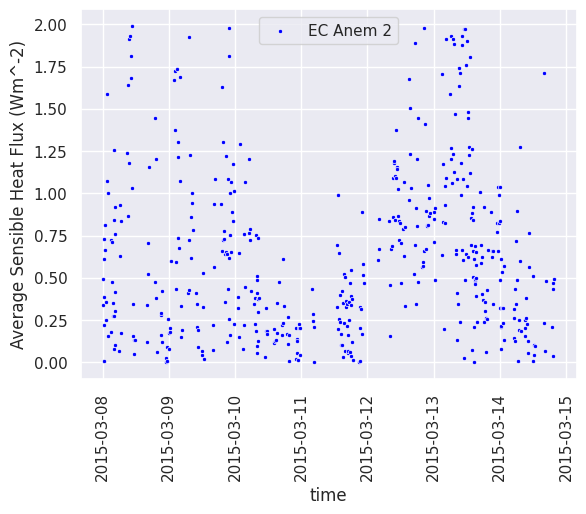

In [26]:
# Olwyn
logDf = outDf[(outDf.time > datetime.datetime(2015, 3, 8, 0, 0)) & (outDf.time < datetime.datetime(2015, 3, 14, 23, 0))]
# mean_ec = apply_window_wise((logDf['HApprox_1'] + logDf['HApprox_2'])/2, WINDOW_WIDTH, np.mean)
# sns.scatterplot(x=logDf['time'], y=(logDf['HApprox_1'] + logDf['HApprox_2'])/2, marker='.', color='blue', label='EC')
mean_ec = apply_window_wise(logDf['HApprox_2'], WINDOW_WIDTH, np.mean)
sns.scatterplot(x=logDf['time'], y=relative_percent_difference(logDf, 'HApprox_1', 'HApprox_2'), marker='.', color='blue', label='EC Anem 2')
# sns.lineplot(data=logDf, x='time', y='HCoare_2', color='orange', label='COARE')
# sns.scatterplot(x=logDf.time[::WINDOW_WIDTH], y=mean_ec, color='green', label='Mean EC Anem 2')
# sns.lineplot(x=logDf.time[::WINDOW_WIDTH], y=mean_ec, color='green')
plt.xlabel('time')
plt.ylabel('Average Sensible Heat Flux (Wm^-2)')
plt.xticks(plt.xticks()[0], rotation=90)
plt.show()

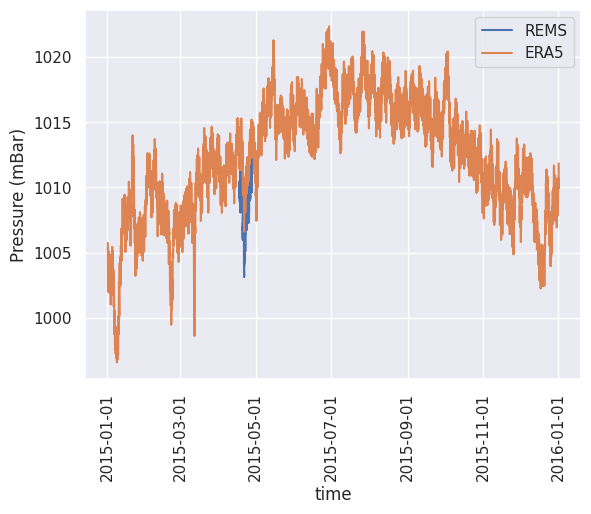

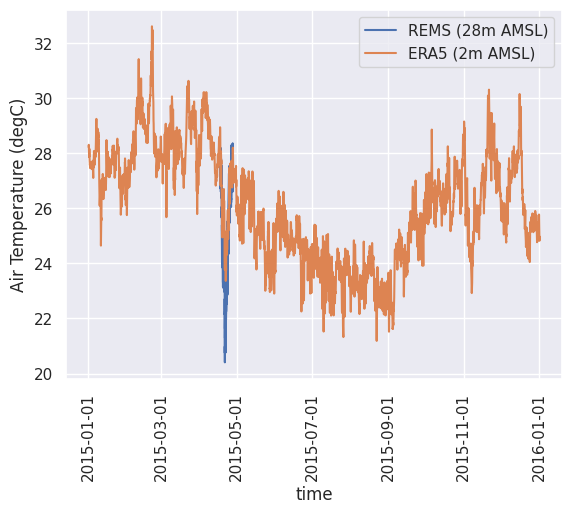

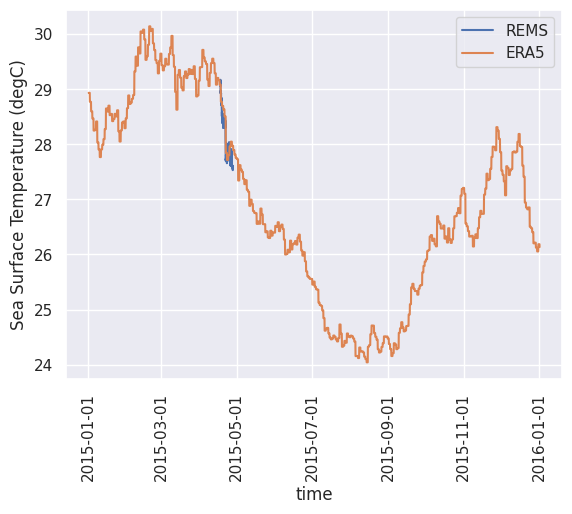

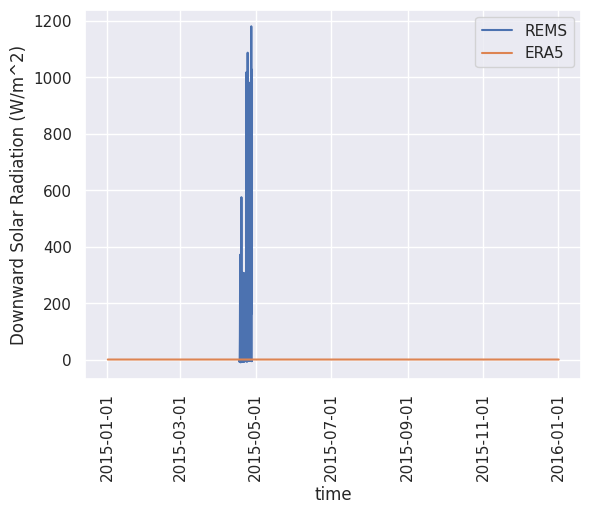

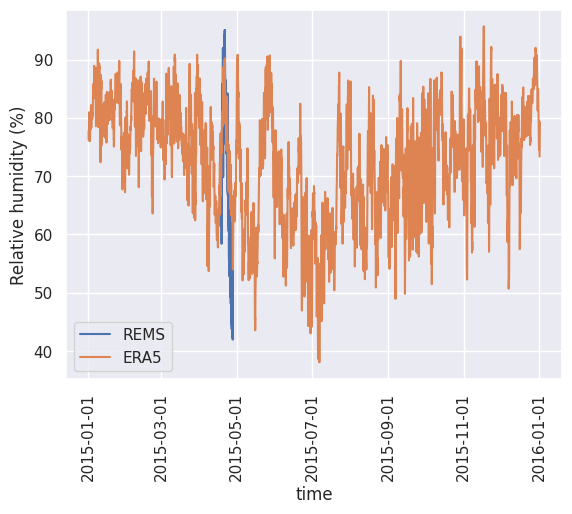

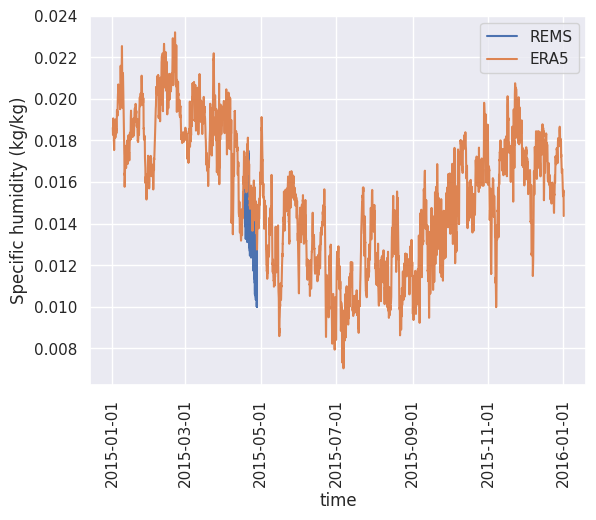

In [35]:
preprocess(eraDf, remsDf, writeDir=None, era_only=era_only, save_plots=False, time_lim=time_lim);

In [31]:
print(len(outDf[pd.notna(outDf.HApprox_1)]))
print(len(outDf[pd.notna(outDf.HApprox_2)]))

9882
9882


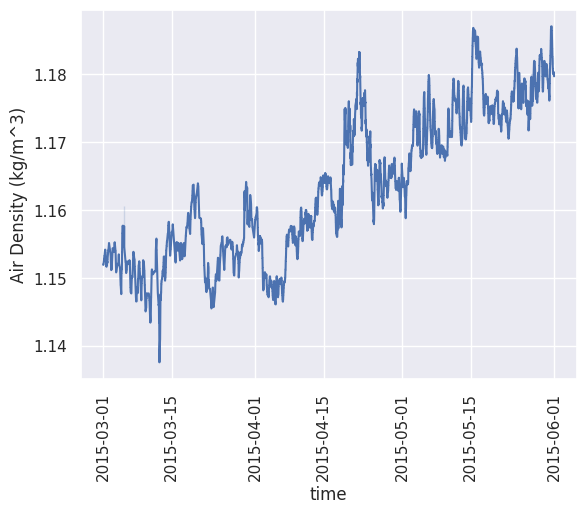

KeyboardInterrupt: 

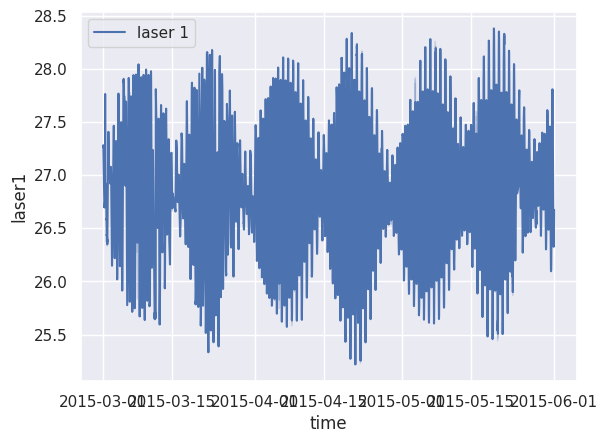

In [36]:
# 2015
postprocess(outDf, eraDf, remsDf, writeDir=None, era_only=era_only, save_plots=False, time_lim=time_lim);00

<AxesSubplot: xlabel='time', ylabel='HApprox_1'>

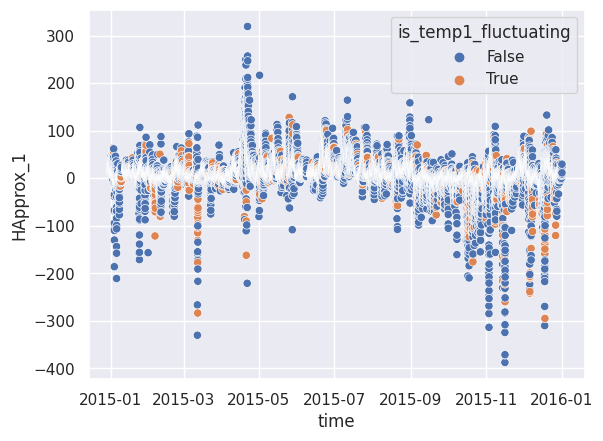

In [237]:
sns.scatterplot(data=outDf, x='time', y='HApprox_1', hue='is_temp1_fluctuating')
# sns.scatterplot(data=outDf[(outDf.time >= time_lim[0]) & (outDf.time <= time_lim[1])], x='time', y='HApprox', hue='is_temp1_fluctuating')

<AxesSubplot: xlabel='time', ylabel='HApprox_1'>

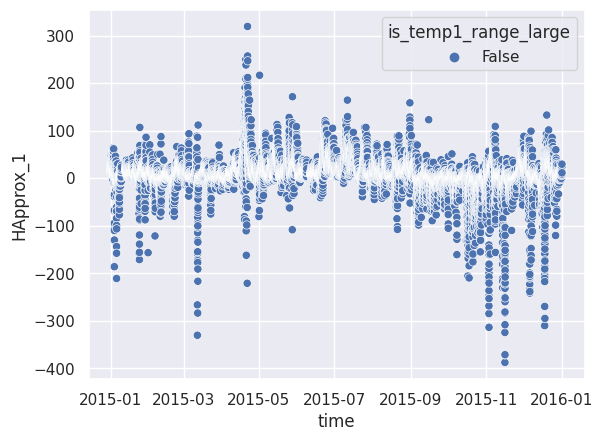

In [239]:
sns.scatterplot(data=outDf, x='time', y='HApprox_1', hue='is_temp1_range_large')

<AxesSubplot: xlabel='time', ylabel='HApprox_2'>

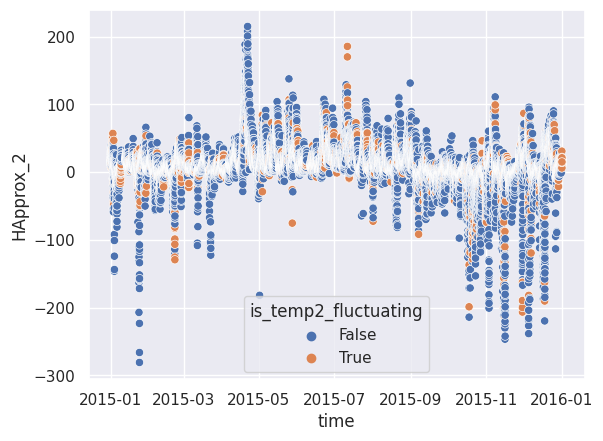

In [240]:
sns.scatterplot(data=outDf, x='time', y='HApprox_2', hue='is_temp2_fluctuating')

(-250.0, 250.0)

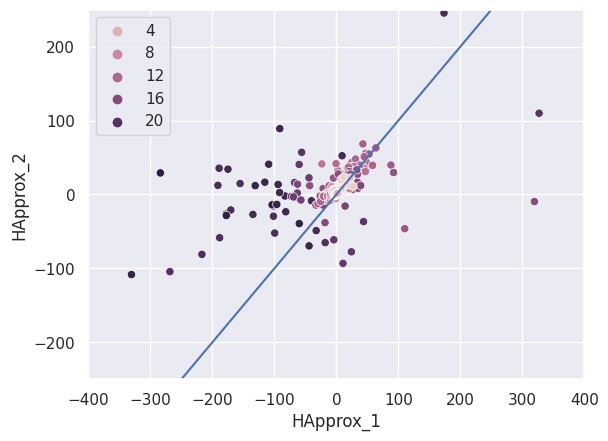

In [24]:
logical = (outDf.time >= time_lim[0]) & (outDf.time <= time_lim[1])
sns.scatterplot(data=outDf[logical], x='HApprox_1', y='HApprox_2', hue='U_anem_1')
sns.lineplot(x=[-400, 400], y=[-400, 400])
plt.xlim([-400, 400])
plt.ylim([-250, 250])

In [24]:
logical = (outDf.time >= time_lim[0]) & (outDf.time <= time_lim[1])
sns.scatterplot(data=outDf[logical], x='HApprox_1', y='HApprox_2', hue='U_anem_1')
sns.lineplot(x=[-400, 400], y=[-400, 400])
plt.xlim([-400, 400])
plt.ylim([-250, 250])

TypeError: 'NoneType' object is not subscriptable

(-100.0, 250.0)

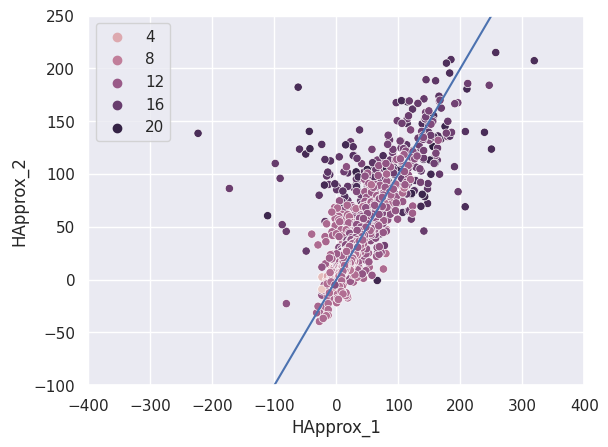

In [27]:
sns.scatterplot(data=outDf, x='HApprox_1', y='HApprox_2', hue='U_anem_1')
sns.lineplot(x=[-400, 400], y=[-400, 400])
plt.xlim([-400, 400])
plt.ylim([-100, 250])

In [ ]:
lin_lims = [min([min(outDf.HCoare_1), min(outDf.HApprox_1)]), max([max(outDf.HCoare_1), max(outDf.HApprox_1)])]
sns.regplot(data=outDf[(outDf.U_anem_1 > 20) & (outDf.U_anem_1 < 15)], x='HCoare_1', y='HApprox_1', label='Anem 1 Best fit with 95% CI')
sns.regplot(data=outDf[outDf.U_anem_1 > 20], x='HCoare_2', y='HApprox_2', label='Anem 2 Best fit with 95% CI')
sns.lineplot(x=lin_lims, y=lin_lims, label='1:1 Fit')
plt.xlabel('COARE')
plt.ylabel('EC')
plt.xlim([-50,100])
plt.title('Sensible Heat Flux (Wm^-2)')
plt.show()

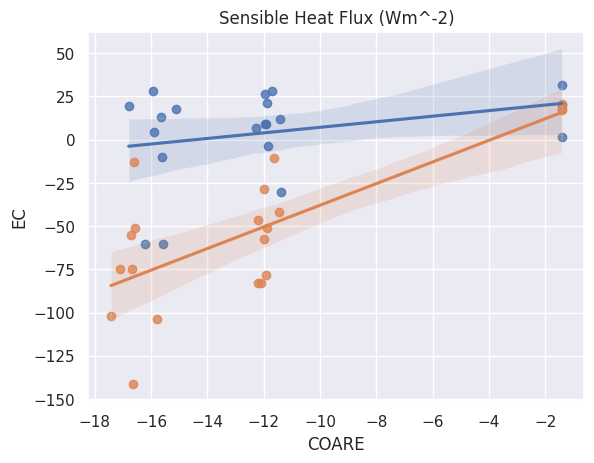

In [94]:
lin_lims = [min([min(outDf.HCoare_1), min(outDf.HApprox_1)]), max([max(outDf.HCoare_1), max(outDf.HApprox_1)])]
sns.regplot(data=outDf[outDf.U_anem_1 > 15], x='HCoare_1', y='HApprox_1', label='Anem 1 Best fit with 95% CI')
sns.regplot(data=outDf[outDf.U_anem_1 > 15], x='HCoare_2', y='HApprox_2', label='Anem 2 Best fit with 95% CI')
sns.lineplot(x=lin_lims, y=lin_lims, label='1:1 Fit')
plt.xlabel('COARE')
plt.ylabel('EC')
# plt.xlim([50,150])
plt.title('Sensible Heat Flux (Wm^-2)')
plt.show()

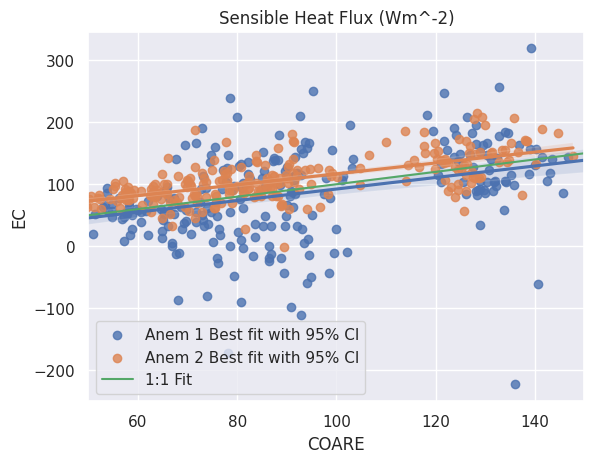

In [85]:
lin_lims = [min([min(outDf.HCoare_1), min(outDf.HApprox_1)]), max([max(outDf.HCoare_1), max(outDf.HApprox_1)])]
sns.regplot(data=outDf[outDf.U_anem_1 > 15], x='HCoare_1', y='HApprox_1', label='Anem 1 Best fit with 95% CI')
sns.regplot(data=outDf[outDf.U_anem_1 > 15], x='HCoare_2', y='HApprox_2', label='Anem 2 Best fit with 95% CI')
sns.lineplot(x=lin_lims, y=lin_lims, label='1:1 Fit')
plt.xlabel('COARE')
plt.ylabel('EC')
plt.xlim([50,150])
plt.title('Sensible Heat Flux (Wm^-2)')
plt.show()

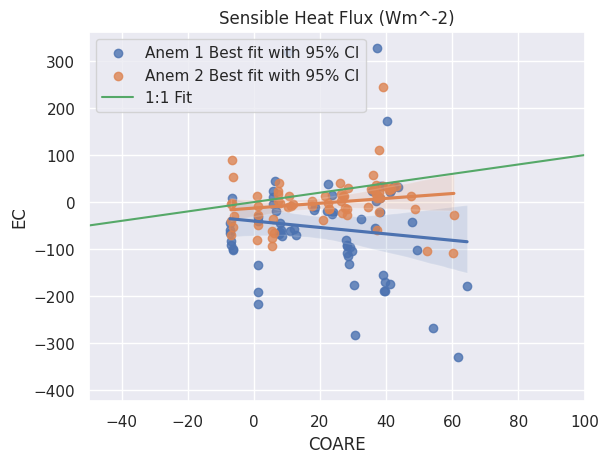

In [91]:
lin_lims = [min([min(outDf.HCoare_1), min(outDf.HApprox_1)]), max([max(outDf.HCoare_1), max(outDf.HApprox_1)])]
sns.regplot(data=outDf[outDf.U_anem_1 > 15], x='HCoare_1', y='HApprox_1', label='Anem 1 Best fit with 95% CI')
sns.regplot(data=outDf[outDf.U_anem_1 > 15], x='HCoare_2', y='HApprox_2', label='Anem 2 Best fit with 95% CI')
sns.lineplot(x=lin_lims, y=lin_lims, label='1:1 Fit')
plt.xlabel('COARE')
plt.ylabel('EC')
plt.xlim([-50,100])
plt.title('Sensible Heat Flux (Wm^-2)')
plt.show()

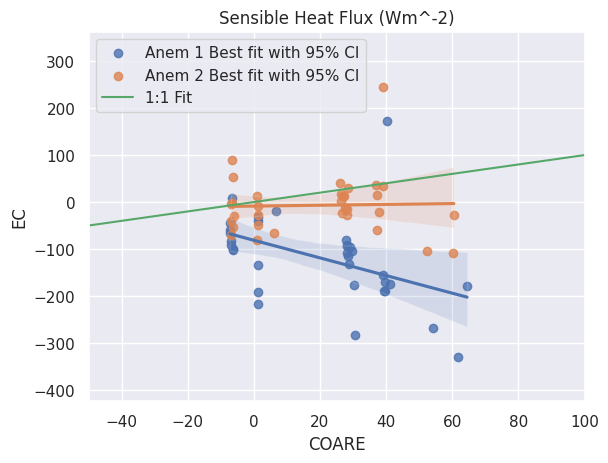

In [77]:
lin_lims = [min([min(outDf.HCoare_1), min(outDf.HApprox_1)]), max([max(outDf.HCoare_1), max(outDf.HApprox_1)])]
sns.regplot(data=outDf[outDf.U_anem_1 > 20], x='HCoare_1', y='HApprox_1', label='Anem 1 Best fit with 95% CI')
sns.regplot(data=outDf[outDf.U_anem_1 > 20], x='HCoare_2', y='HApprox_2', label='Anem 2 Best fit with 95% CI')
sns.lineplot(x=lin_lims, y=lin_lims, label='1:1 Fit')
plt.xlabel('COARE')
plt.ylabel('EC')
plt.xlim([-50,100])
plt.title('Sensible Heat Flux (Wm^-2)')
plt.show()

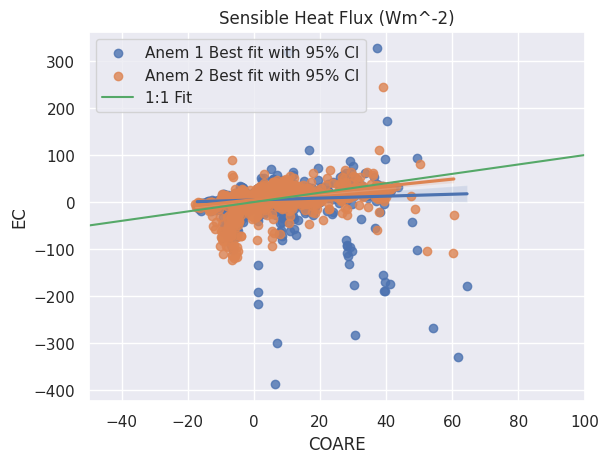

In [19]:
lin_lims = [min([min(outDf.HCoare_1), min(outDf.HApprox_1)]), max([max(outDf.HCoare_1), max(outDf.HApprox_1)])]
sns.regplot(data=outDf, x='HCoare_1', y='HApprox_1', label='Anem 1 Best fit with 95% CI')
sns.regplot(data=outDf, x='HCoare_2', y='HApprox_2', label='Anem 2 Best fit with 95% CI')
sns.lineplot(x=lin_lims, y=lin_lims, label='1:1 Fit')
plt.xlabel('COARE')
plt.ylabel('EC')
plt.xlim([-50,100])
plt.title('Sensible Heat Flux (Wm^-2)')
plt.show()

(-250.0, 250.0)

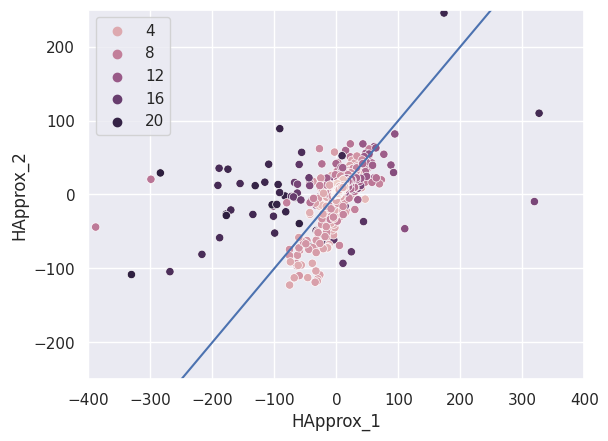

In [20]:
sns.scatterplot(data=outDf, x='HApprox_1', y='HApprox_2', hue='U_anem_2')
sns.lineplot(x=[-400, 400], y=[-400, 400])
plt.xlim([-400, 400])
plt.ylim([-250, 250])

<AxesSubplot: xlabel='time', ylabel='Sensible Heat Flux Wm^-2'>

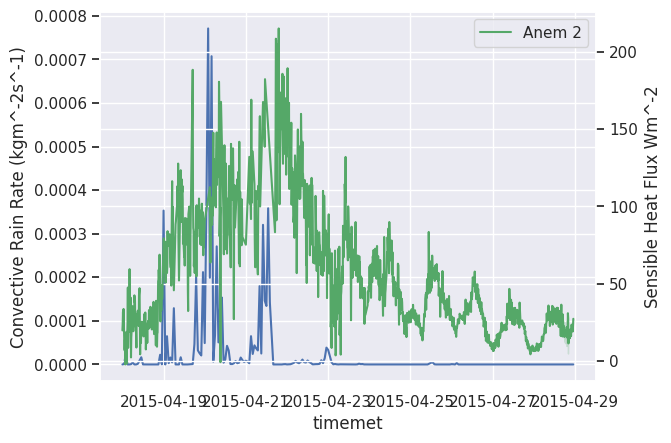

In [42]:
logicalOut = (outDf.time >= time_lim[0]) & (outDf.time <= time_lim[1])
logicalEra = (eraDf.timemet >= time_lim[0]) & (eraDf.timemet <= time_lim[1])
sns.lineplot(x=eraDf[logicalEra].timemet, y=eraDf[logicalEra].crr)
plt.ylabel('Convective Rain Rate (kgm^-2s^-1)')
ax2 = plt.twinx()
ax2.set_ylabel('Sensible Heat Flux Wm^-2')
sns.lineplot(data=outDf[logicalOut], x='time', y='HApprox_2', ax=ax2, color='g', label='Anem 2')

<AxesSubplot: xlabel='time', ylabel='Sensible Heat Flux Wm^-2'>

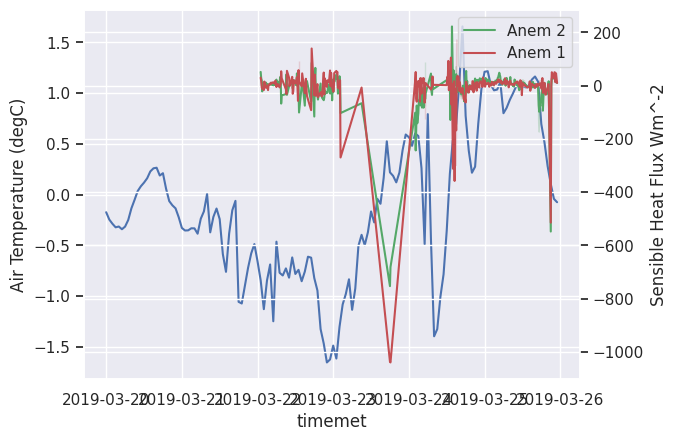

In [96]:
logicalOut = (outDf.time >= time_lim[0]) & (outDf.time <= time_lim[1])
logicalEra = (eraDf.timemet >= time_lim[0]) & (eraDf.timemet <= time_lim[1])
sns.lineplot(x=eraDf[logicalEra].timemet, y=eraDf[logicalEra].ta-eraDf[logicalEra].tsea)
# sns.lineplot(data=outDf[logicalOut], x='time', y='HApprox_2', label='Anem 2 Sensible Heat Flux')
# plt.ylabel('Energy Flux (Wm^-2)')
plt.ylabel('Air Temperature (degC)')
ax2 = plt.twinx()
ax2.set_ylabel('Sensible Heat Flux Wm^-2')
sns.lineplot(data=outDf[logicalOut], x='time', y='HApprox_2', ax=ax2, color='g', label='Anem 2')
sns.lineplot(data=outDf[logicalOut], x='time', y='HApprox_1', ax=ax2, color='r', label='Anem 1')

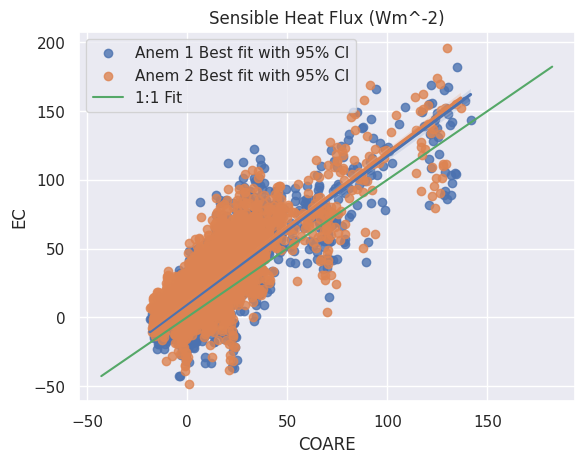

In [51]:
# 2015
logDf = outDf[np.abs(outDf['HApprox_2'] - outDf['HApprox_1']) < 20]
lin_lims = [min([min(logDf.HCoare_1), min(logDf.HApprox_1)]), max([max(logDf.HCoare_1), max(logDf.HApprox_1)])]
sns.regplot(data=logDf, x='HCoare_1', y='HApprox_1', label='Anem 1 Best fit with 95% CI')
sns.regplot(data=logDf, x='HCoare_2', y='HApprox_2', label='Anem 2 Best fit with 95% CI')
sns.lineplot(x=lin_lims, y=lin_lims, label='1:1 Fit')
plt.xlabel('COARE')
plt.ylabel('EC')
# plt.xlim([50,150])
plt.title('Sensible Heat Flux (Wm^-2)')
plt.show()

In [ ]:
# 2015
sns.scatterplot(data=outDf, x='U_anem_1', y='HApprox_1', label='Anem 1')
sns.scatterplot(data=outDf, x='U_anem_2', y='HApprox_2', label='Anem 2')
plt.xlabel('Windspeed (m/s)')
plt.ylabel('Sensible Heat Flux (Wm^-2)')

Text(0, 0.5, 'Sensible Heat Flux (Wm^-2)')

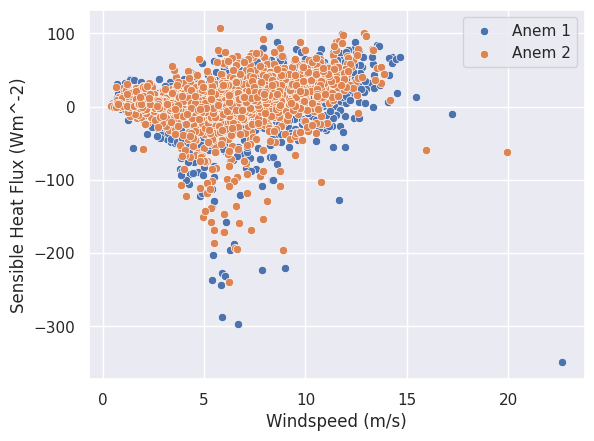

In [253]:
# 2015 60min
sns.scatterplot(data=outDf, x='U_anem_1', y='HApprox_1', label='Anem 1')
sns.scatterplot(data=outDf, x='U_anem_2', y='HApprox_2', label='Anem 2')
plt.xlabel('Windspeed (m/s)')
plt.ylabel('Sensible Heat Flux (Wm^-2)')

In [137]:
print(len(outDf[np.abs(outDf['HApprox_2'] - outDf['HApprox_1']) < 20])/len(outDf))

0.9066933066933067


Text(0, 0.5, 'Sensible Heat Flux (Wm^-2)')

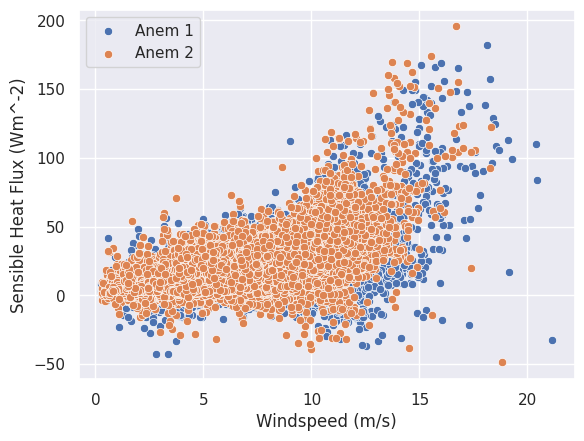

In [43]:
# 2015
logDf = outDf[np.abs(outDf['HApprox_2'] - outDf['HApprox_1']) < 20]
sns.scatterplot(x=logDf['U_anem_1'], y=logDf['HApprox_1'], label='Anem 1')
sns.scatterplot(x=logDf['U_anem_2'], y=logDf['HApprox_2'], label='Anem 2')
plt.xlabel('Windspeed (m/s)')
plt.ylabel('Sensible Heat Flux (Wm^-2)')

Text(0, 0.5, 'Sensible Heat Flux (Wm^-2)')

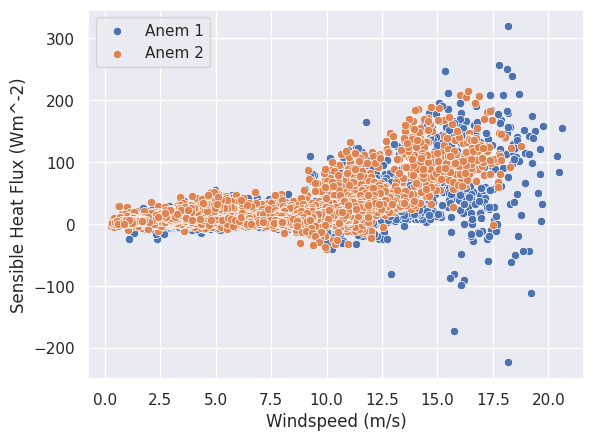

In [8]:
# QUANG
sns.scatterplot(data=outDf, x='U_anem_1', y='HApprox_1', label='Anem 1')
sns.scatterplot(data=outDf, x='U_anem_2', y='HApprox_2', label='Anem 2')
plt.xlabel('Windspeed (m/s)')
plt.ylabel('Sensible Heat Flux (Wm^-2)')

<AxesSubplot: xlabel='time'>

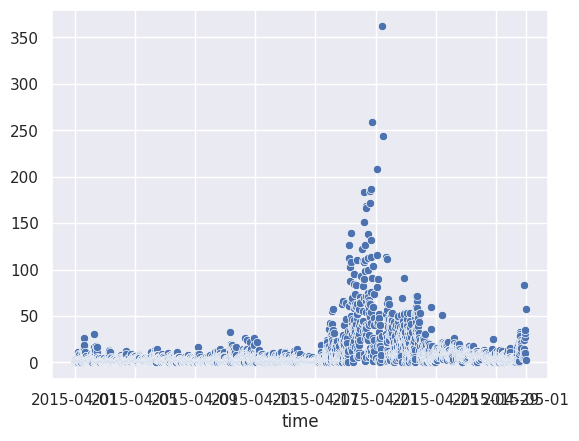

In [9]:
# QUANG
sns.scatterplot(x=outDf.time, y=np.abs(outDf['HApprox_2'] - outDf['HApprox_1']))

In [10]:
print(len(outDf[np.abs(outDf['HApprox_2'] - outDf['HApprox_1']) < 25])/len(outDf))

0.8904847396768402


In [15]:
print(len(outDf[np.abs(outDf['HApprox_2'] - outDf['HApprox_1']) < 25]))

3472


In [16]:
print(len(outDf))

3899


Text(0, 0.5, 'Sensible Heat Flux (Wm^-2)')

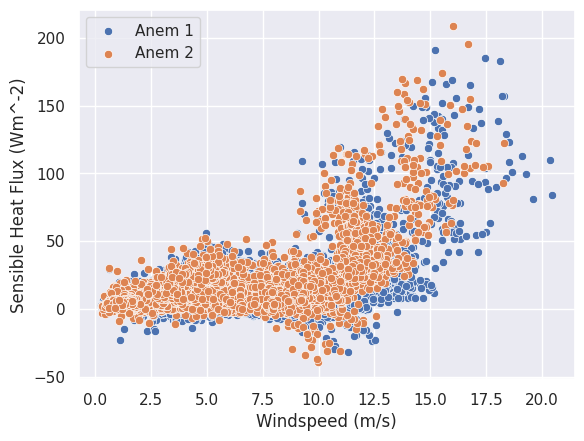

In [22]:
# QUANG
logDf = outDf[np.abs(outDf['HApprox_2'] - outDf['HApprox_1']) < 25]
sns.scatterplot(x=logDf['U_anem_1'], y=logDf['HApprox_1'], label='Anem 1')
sns.scatterplot(x=logDf['U_anem_2'], y=logDf['HApprox_2'], label='Anem 2')
plt.xlabel('Windspeed (m/s)')
plt.ylabel('Sensible Heat Flux (Wm^-2)')

([<matplotlib.axis.XTick at 0x7f40d3928100>,
 [Text(16544.0, 0, '2015-04-19'),
  Text(16546.0, 0, '2015-04-21'),
  Text(16548.0, 0, '2015-04-23'),
  Text(16550.0, 0, '2015-04-25'),
  Text(16552.0, 0, '2015-04-27'),
  Text(16554.0, 0, '2015-04-29')])

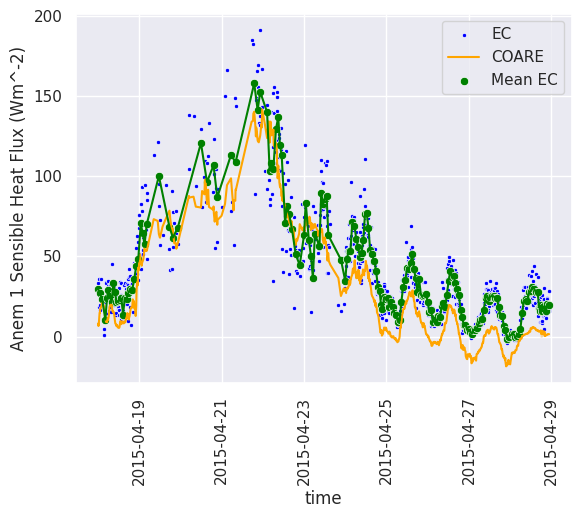

In [23]:
# QUANG
outDf = logDf # NOTE THIS!!
outDf = outDf[(outDf.time > datetime.datetime(2015, 4, 18, 0, 0)) & (outDf.time < datetime.datetime(2015, 4, 28, 23, 0))]
mean_ec = apply_window_wise((outDf['HApprox_1']), WINDOW_WIDTH, np.mean)
sns.scatterplot(x=outDf['time'], y=(outDf['HApprox_1']), marker='.', color='blue', label='EC')
sns.lineplot(data=outDf, x='time', y='HCoare_1', color='orange', label='COARE')
sns.scatterplot(x=outDf.time[::WINDOW_WIDTH], y=mean_ec, color='green', label='Mean EC')
sns.lineplot(x=outDf.time[::WINDOW_WIDTH], y=mean_ec, color='green')
plt.xlabel('time')
plt.ylabel('Anem 1 Sensible Heat Flux (Wm^-2)')
plt.xticks(plt.xticks()[0], rotation=90)

([<matplotlib.axis.XTick at 0x7f40cb50a640>,
 [Text(16544.0, 0, '2015-04-19'),
  Text(16546.0, 0, '2015-04-21'),
  Text(16548.0, 0, '2015-04-23'),
  Text(16550.0, 0, '2015-04-25'),
  Text(16552.0, 0, '2015-04-27'),
  Text(16554.0, 0, '2015-04-29')])

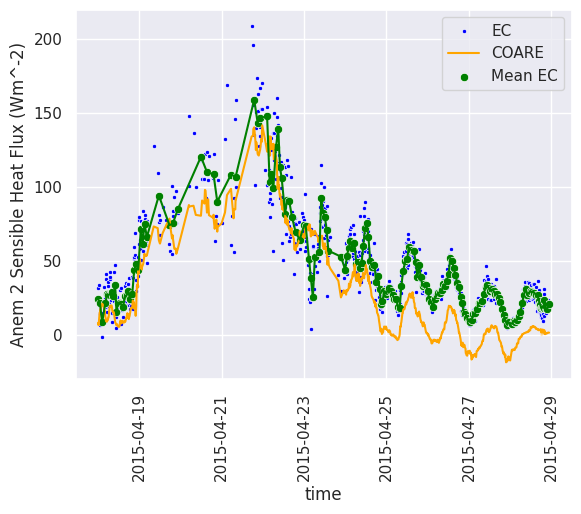

In [24]:
# QUANG
outDf = logDf # NOTE THIS!!
outDf = outDf[(outDf.time > datetime.datetime(2015, 4, 18, 0, 0)) & (outDf.time < datetime.datetime(2015, 4, 28, 23, 0))]
mean_ec = apply_window_wise((outDf['HApprox_2']), WINDOW_WIDTH, np.mean)
sns.scatterplot(x=outDf['time'], y=(outDf['HApprox_2']), marker='.', color='blue', label='EC')
sns.lineplot(data=outDf, x='time', y='HCoare_1', color='orange', label='COARE')
sns.scatterplot(x=outDf.time[::WINDOW_WIDTH], y=mean_ec, color='green', label='Mean EC')
sns.lineplot(x=outDf.time[::WINDOW_WIDTH], y=mean_ec, color='green')
plt.xlabel('time')
plt.ylabel('Anem 2 Sensible Heat Flux (Wm^-2)')
plt.xticks(plt.xticks()[0], rotation=90)

Text(0, 0.5, 'Average Sensible Heat Flux (Wm^-2)')

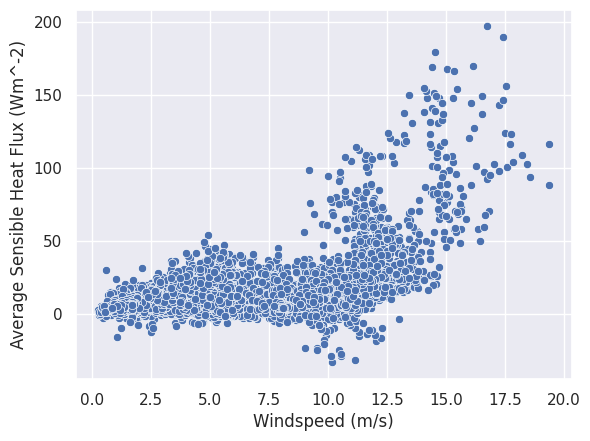

In [30]:
# QUANG
sns.scatterplot(data=logDf, x=(logDf['U_anem_1'] + logDf['U_anem_2'])/2, y=(logDf['HApprox_1'] + logDf['HApprox_2'])/2)
plt.xlabel('Windspeed (m/s)')
plt.ylabel('Average Sensible Heat Flux (Wm^-2)')

Text(0, 0.5, 'Sensible Heat Flux (Wm^-2)')

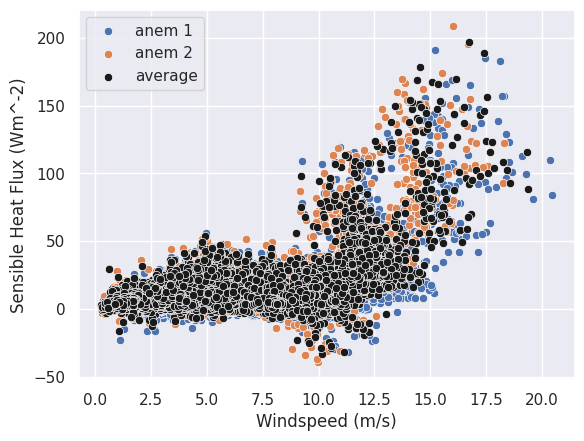

In [32]:
# QUANG
sns.scatterplot(data=logDf, x='U_anem_1', y='HApprox_1', label='anem 1')
sns.scatterplot(data=logDf, x='U_anem_2', y='HApprox_2', label='anem 2')
sns.scatterplot(data=logDf, x=(logDf['U_anem_1'] + logDf['U_anem_2'])/2, y=(logDf['HApprox_1'] + logDf['HApprox_2'])/2, label='average', color='k')
plt.xlabel('Windspeed (m/s)')
plt.ylabel('Sensible Heat Flux (Wm^-2)')

([<matplotlib.axis.XTick at 0x7f40cb538400>,
 [Text(16544.0, 0, '2015-04-19'),
  Text(16546.0, 0, '2015-04-21'),
  Text(16548.0, 0, '2015-04-23'),
  Text(16550.0, 0, '2015-04-25'),
  Text(16552.0, 0, '2015-04-27'),
  Text(16554.0, 0, '2015-04-29')])

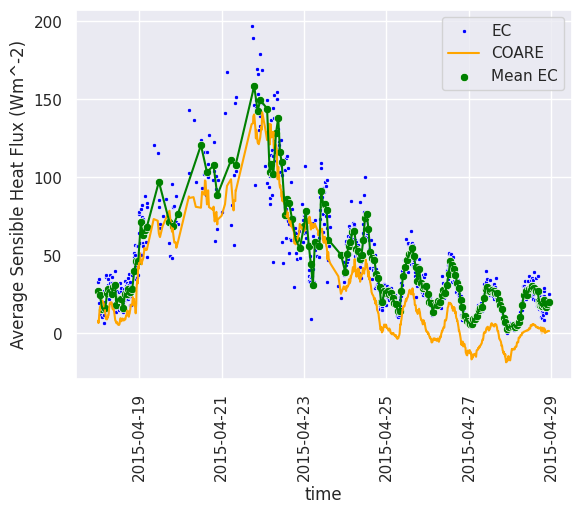

In [28]:
# QUANG
outDf = logDf # NOTE THIS!!
outDf = outDf[(outDf.time > datetime.datetime(2015, 4, 18, 0, 0)) & (outDf.time < datetime.datetime(2015, 4, 28, 23, 0))]
mean_ec = apply_window_wise((outDf['HApprox_1'] + outDf['HApprox_2'])/2, WINDOW_WIDTH, np.mean)
sns.scatterplot(x=outDf['time'], y=(outDf['HApprox_1'] + outDf['HApprox_2'])/2, marker='.', color='blue', label='EC')
sns.lineplot(data=outDf, x='time', y='HCoare_1', color='orange', label='COARE')
sns.scatterplot(x=outDf.time[::WINDOW_WIDTH], y=mean_ec, color='green', label='Mean EC')
sns.lineplot(x=outDf.time[::WINDOW_WIDTH], y=mean_ec, color='green')
plt.xlabel('time')
plt.ylabel('Average Sensible Heat Flux (Wm^-2)')
plt.xticks(plt.xticks()[0], rotation=90)

(-100.0, 250.0)

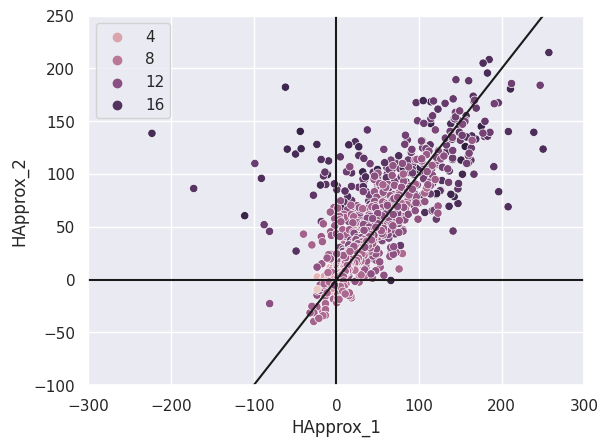

In [17]:
# QUANG
sns.lineplot(x=[0, 1e-10], y=[-400, 400], color='k')
sns.lineplot(x=[-400, 400], y=[0, 0], color='k')
sns.scatterplot(data=outDf, x='HApprox_1', y='HApprox_2', hue='U_anem_2')
sns.lineplot(x=[-400, 400], y=[-400, 400], color='k')
plt.xlim([-300, 300])
plt.ylim([-100, 250])

<AxesSubplot: xlabel='U_anem_1', ylabel='U_anem_2'>

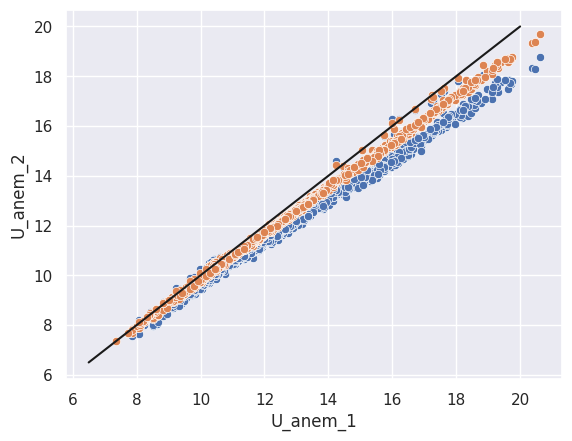

In [51]:
# QUANG
sns.scatterplot(data=outDf, x='U_anem_1', y='U_anem_2')
sns.scatterplot(data=outDf, x='U_anem_1', y=(outDf['U_anem_1'] + outDf['U_anem_2'])/2)
sns.lineplot(x=[6.5, 20], y=[6.5, 20], color='k')

<AxesSubplot: xlabel='time'>

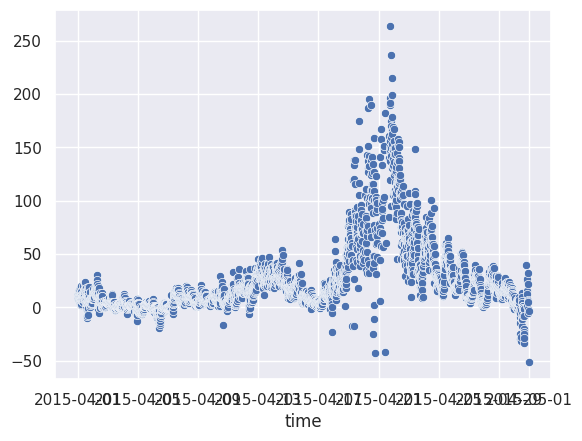

In [99]:
# QUANG
sns.scatterplot(x=outDf.time, y=(outDf['HApprox_1'] + outDf['HApprox_2'])/2)

In [93]:
# QUANG
np.mean(outDf['HApprox_2'] - outDf['HApprox_1'])

3.7296930174637595

<AxesSubplot: >

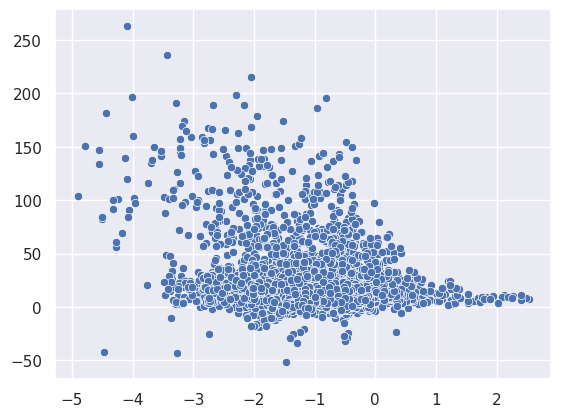

In [128]:
# QUANG
sns.scatterplot(x=eraDf.ta - eraDf.tsea, y=(outDf['HApprox_1'] + outDf['HApprox_2'])/2)
# sns.scatterplot(x=eraDf.ta - eraDf.tsea, y=(outDf['HApprox_1']))
# sns.scatterplot(x=eraDf.ta - eraDf.tsea, y=(outDf['HApprox_2']))

<AxesSubplot: xlabel='U_anem_1', ylabel='HApprox_1'>

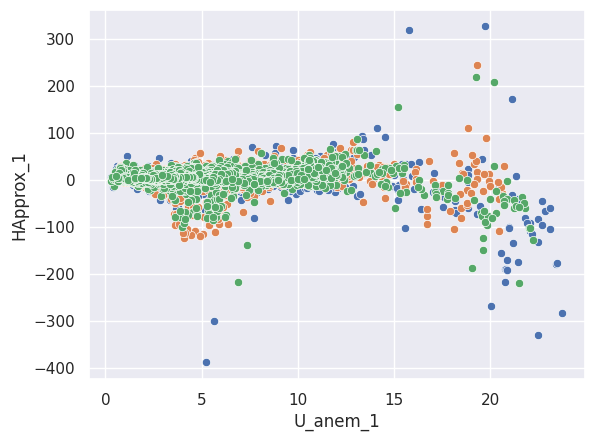

In [110]:
# OLWYN
sns.scatterplot(data=outDf, x='U_anem_1', y='HApprox_1')
sns.scatterplot(data=outDf, x='U_anem_2', y='HApprox_2')
sns.scatterplot(data=outDf, x=(outDf['U_anem_1'] + outDf['U_anem_2'])/2, y=(outDf['HApprox_1'] + outDf['HApprox_2'])/2)

<AxesSubplot: ylabel='HApprox_1'>

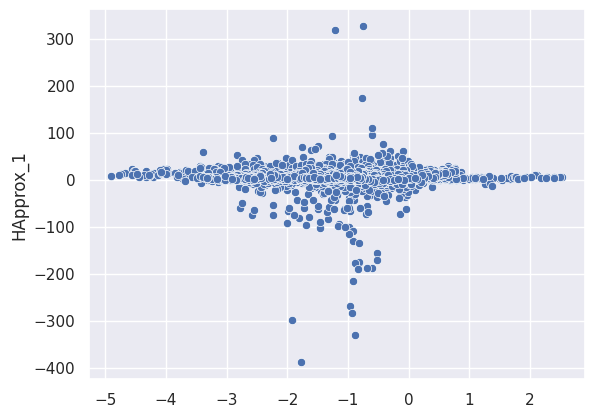

In [124]:
# OLWYN
# sns.scatterplot(x=eraDf.ta - eraDf.tsea, y=(outDf['HApprox_1'] + outDf['HApprox_2'])/2)
sns.scatterplot(x=eraDf.ta - eraDf.tsea, y=(outDf['HApprox_1']))
# sns.scatterplot(x=eraDf.ta - eraDf.tsea, y=(outDf['HApprox_2']))

<AxesSubplot: >

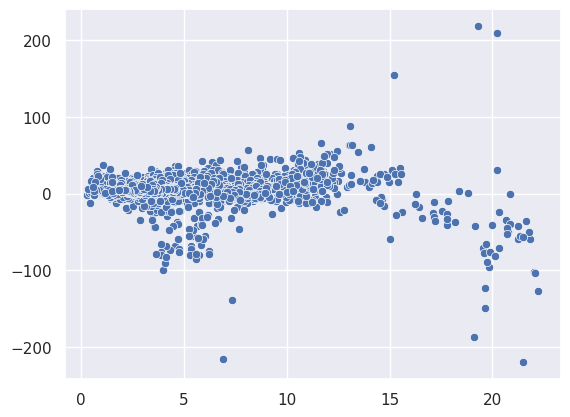

In [111]:
# OLWYN
sns.scatterplot(data=outDf, x=(outDf['U_anem_1'] + outDf['U_anem_2'])/2, y=(outDf['HApprox_1'] + outDf['HApprox_2'])/2)

<AxesSubplot: xlabel='time'>

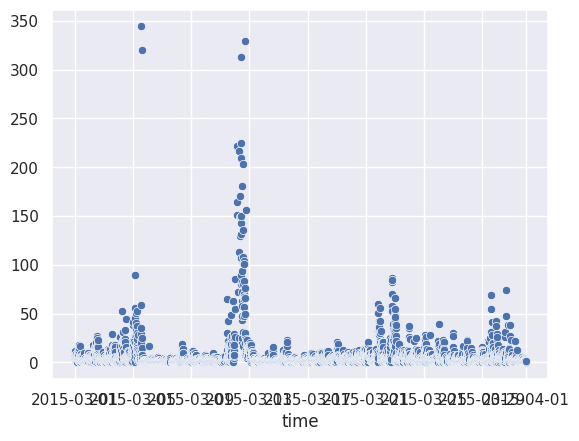

In [130]:
# QUANG
sns.scatterplot(x=outDf.time, y=np.abs(outDf['HApprox_2'] - outDf['HApprox_1']))

In [146]:
len(outDf[pd.isna(outDf.HApprox_2)])

0

In [10]:
print(len(outDf[np.abs(outDf['HApprox_2'] - outDf['HApprox_1']) < 100])/len(outDf))

0.9936215450035436


In [38]:
print(len(outDf[np.abs(outDf['HApprox_2'] - outDf['HApprox_1']) < 12]))

3819


In [39]:
print(len(outDf))

4233


In [40]:
(4233-3819)/4233

0.09780297661233169

<AxesSubplot: xlabel='time'>

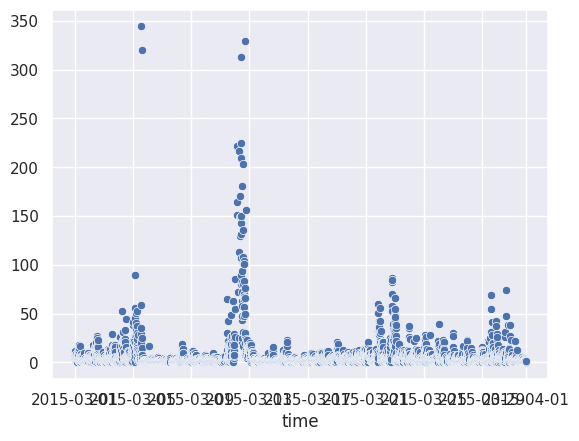

In [36]:
# OLWYN
sns.scatterplot(x=outDf.time, y=np.abs(outDf['HApprox_2'] - outDf['HApprox_1']))

Text(0, 0.5, 'Sensible Heat Flux (Wm^-2)')

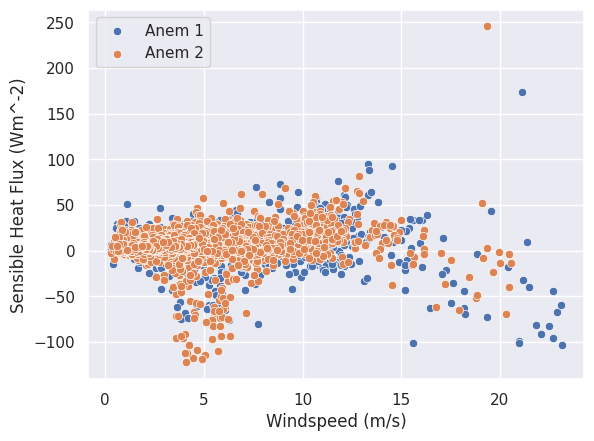

In [9]:
# OLWYN
logDf = outDf[np.abs(outDf['HApprox_2'] - outDf['HApprox_1']) < 100]
sns.scatterplot(x=logDf['U_anem_1'], y=logDf['HApprox_1'], label='Anem 1')
sns.scatterplot(x=logDf['U_anem_2'], y=logDf['HApprox_2'], label='Anem 2')
plt.xlabel('Windspeed (m/s)')
plt.ylabel('Sensible Heat Flux (Wm^-2)')